# Unsupervised Anomaly Detection

> ##### Load Data

In [1]:
import json
import pandas as pd
from datetime import datetime
import ipaddress

datafile = './data/collect_log_ba_202304071701.json'

with open( datafile, 'r', encoding='utf-8' ) as f:
    data = json.loads(f.read())

df = pd.json_normalize( data, record_path=['collect_log_ba'])


> ##### remove column log_seq 

In [69]:
df[df.columns[1:]]

,user_id,user_name,dept_id,dept_name,log_time,req_type,req_url,log_type_cd,user_ip,proc_date,proc_time,system_seq,normal_flag
0,USER0,이름0,DEPT10003,부서명10003,2023-01-01T00:12:03.000Z,등록,www.easycerti.com,cl,192.168.0.18,20230101,09120,5,0
1,USER5,이름5,DEPT10008,부서명10008,2023-01-01T03:02:11.000Z,등록,www.easycerti.com/view/detial,cl,192.222.0.16,20230101,12021,1,0
2,USER1,이름1,DEPT10004,부서명10004,2023-01-01T08:04:23.000Z,조회,www.test.com,dn,192.18.0.26,20230101,17042,4,0
3,USER3,이름3,DEPT10006,부서명10006,2023-01-01T06:13:05.000Z,조회,www.easycerti.com/view/detial,ba,192.168.0.18,20230101,15130,1,0
4,USER5,이름5,DEPT10008,부서명10008,2023-01-01T05:21:18.000Z,조회,www.easycerti.com,ba,192.168.0.18,20230101,14211,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,USER1,이름1,DEPT10004,부서명10004,2023-04-03T01:22:00.000Z,조회,localhost:8080/board/qna/detail/view,cl,0.0.0.1,20230403,10220,4,0
19993,USER1,이름1,DEPT10004,부서명10004,2023-04-03T08:17:19.000Z,조회,www.kakao.com,db,192.168.0.12,20230403,17171,1,0
19994,USER4,이름4,DEPT10007,부서명10007,2023-04-03T06:06:00.000Z,조회,www.koera.kr,db,12.18.0.22,20230403,15060,5,0
19995,USER6,이름6,DEPT10009,부서명10009,2023-04-03T06:09:00.000Z,삭제,www.kakao.com,dn,0.0.0.1,20230403,15090,5,0


> ##### 데이터 정합성 판단

In [70]:
df.isna().sum()

log_seq        0
user_id        0
user_name      0
dept_id        0
dept_name      0
log_time       0
req_type       0
req_url        0
log_type_cd    0
user_ip        0
proc_date      0
proc_time      0
system_seq     0
normal_flag    0
dtype: int64

> ##### proc_time replace

In [4]:
# df['proc_time'] = df.log_time.str.split('T').str[1]\
#                              .str.split('.').str[0]

# df['proc_date'] = df.proc_date.astype('datetime64[ns]')
# df['proc_time'] = df.proc_time.astype('datetime64[ns]').apply(pd.Timestamp.time)
# df
time_df = df['log_time'].apply( pd.Timestamp )

df['log_time'] = time_df
df['proc_time'] = time_df.dt.time
df['proc_date'] = time_df.dt.date.astype('datetime64[ns]')

> ##### clone Data

In [5]:
df.rename( columns={'normal_flag' : 'anomaly_flag' }, inplace=True )

In [6]:
new_df = df[['user_id', 'dept_id', 'log_time', 'req_type',
       'req_url', 'log_type_cd', 'user_ip', 'proc_date', 'proc_time',
       'system_seq', 'anomaly_flag']].copy()
new_df

,user_id,dept_id,log_time,req_type,req_url,log_type_cd,user_ip,proc_date,proc_time,system_seq,anomaly_flag
0,USER0,DEPT10003,2023-01-01 00:12:03+00:00,등록,www.easycerti.com,cl,192.168.0.18,2023-01-01,00:12:03,5,0
1,USER5,DEPT10008,2023-01-01 03:02:11+00:00,등록,www.easycerti.com/view/detial,cl,192.222.0.16,2023-01-01,03:02:11,1,0
2,USER1,DEPT10004,2023-01-01 08:04:23+00:00,조회,www.test.com,dn,192.18.0.26,2023-01-01,08:04:23,4,0
3,USER3,DEPT10006,2023-01-01 06:13:05+00:00,조회,www.easycerti.com/view/detial,ba,192.168.0.18,2023-01-01,06:13:05,1,0
4,USER5,DEPT10008,2023-01-01 05:21:18+00:00,조회,www.easycerti.com,ba,192.168.0.18,2023-01-01,05:21:18,5,0
...,...,...,...,...,...,...,...,...,...,...,...
19992,USER1,DEPT10004,2023-04-03 01:22:00+00:00,조회,localhost:8080/board/qna/detail/view,cl,0.0.0.1,2023-04-03,01:22:00,4,0
19993,USER1,DEPT10004,2023-04-03 08:17:19+00:00,조회,www.kakao.com,db,192.168.0.12,2023-04-03,08:17:19,1,0
19994,USER4,DEPT10007,2023-04-03 06:06:00+00:00,조회,www.koera.kr,db,12.18.0.22,2023-04-03,06:06:00,5,0
19995,USER6,DEPT10009,2023-04-03 06:09:00+00:00,삭제,www.kakao.com,dn,0.0.0.1,2023-04-03,06:09:00,5,0


> ##### catagorical
> - 관측할 범주의 범위를 미리 비정할수 있도록 추후 category를 확정한다.

In [7]:
# category ( 범주형 ) 데이터로 변경
new_df['req_type'] = new_df['req_type'].astype( 'category' )
new_df['log_type_cd'] = new_df['log_type_cd'].astype( 'category' )
new_df['system_seq'] = new_df['system_seq'].astype( 'category' )
new_df['user_id'] = new_df['user_id'].astype( 'category' )
new_df['dept_id'] = new_df['dept_id'].astype( 'category' )
new_df['anomaly_flag'] = new_df['anomaly_flag'].astype( 'category' )
new_df['user_ip'] = new_df['user_ip'].apply(ipaddress.IPv4Address).apply(int)

In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   user_id       19997 non-null  category           
 1   dept_id       19997 non-null  category           
 2   log_time      19997 non-null  datetime64[ns, UTC]
 3   req_type      19997 non-null  category           
 4   req_url       19997 non-null  object             
 5   log_type_cd   19997 non-null  category           
 6   user_ip       19997 non-null  int64              
 7   proc_date     19997 non-null  datetime64[ns]     
 8   proc_time     19997 non-null  object             
 9   system_seq    19997 non-null  category           
 10  anomaly_flag  19997 non-null  category           
dtypes: category(6), datetime64[ns, UTC](1), datetime64[ns](1), int64(1), object(2)
memory usage: 899.9+ KB


> ##### Total data

In [99]:
df.shape

(19997, 14)

In [172]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

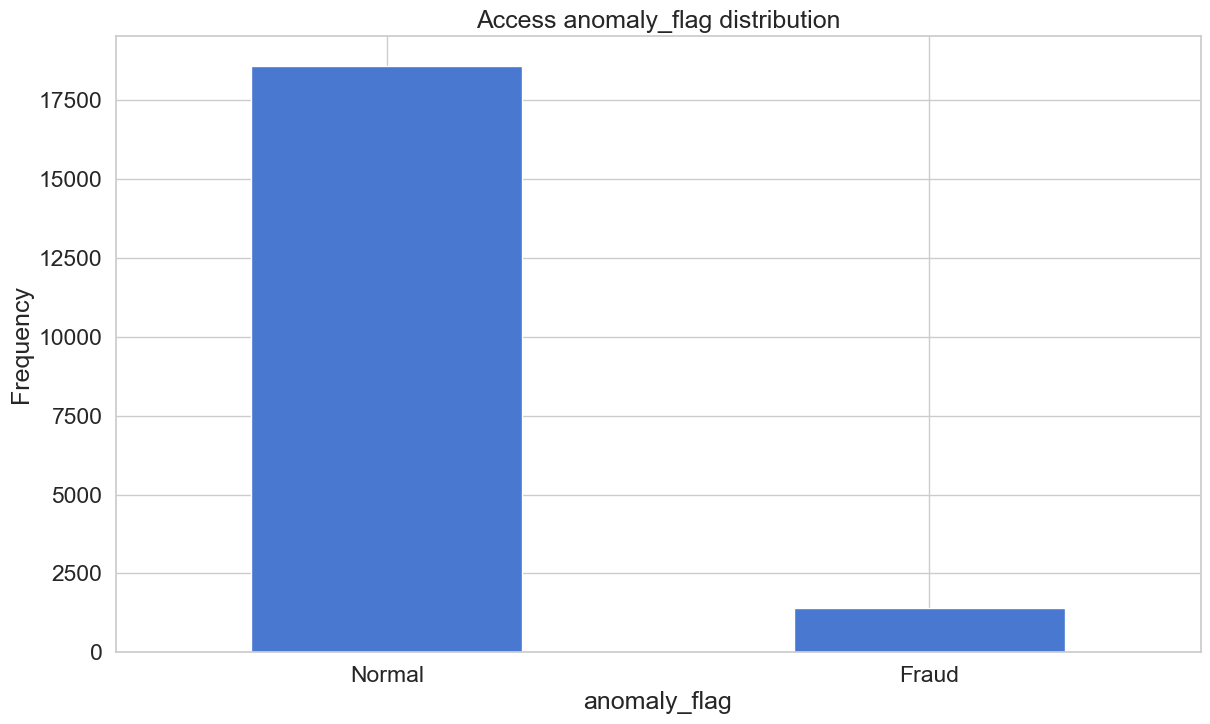

In [173]:
count_classes = pd.value_counts(new_df['anomaly_flag'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Access anomaly_flag distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("anomaly_flag")
plt.ylabel("Frequency");

> ##### True, False data ratio

In [81]:
new_df.anomaly_flag.unique()

array([0, 1], dtype=int64)

In [114]:
new_df[new_df['anomaly_flag'] == 1].shape, new_df[new_df['anomaly_flag'] == 0].shape

((1396, 10), (18601, 10))

In [174]:
frauds = new_df[new_df.anomaly_flag == 1]
normal = new_df[new_df.anomaly_flag == 0]

In [16]:
new_df.columns

Index(['user_id', 'dept_id', 'log_time', 'req_type', 'req_url', 'log_type_cd',
       'user_ip', 'proc_date', 'proc_time', 'system_seq', 'anomaly_flag'],
      dtype='object')

In [129]:
new_df['log_time'] = df['log_time'].apply( pd.Timestamp )

In [10]:
new_df.groupby(["proc_date","proc_time"]).agg({"anomaly_flag":"count"})

anomaly_flag
proc_date  proc_time              
2022-12-31 16:03:09              1
           16:06:05              1
           16:13:17              1
           16:18:21              1
           16:20:03              1
...                            ...
2023-04-03 08:19:16              1
           08:20:00              1
           08:20:15              1
           08:21:19              1
           08:23:08              1

[19667 rows x 1 columns]

In [20]:
data = new_df.copy()

> ##### ref
[using Semi Supervised Learning](https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders/notebook)   
[웹서버 로그 데이터의 이상상태 탐지 기법](https://koreascience.kr/article/JAKO201905653788969.pdf)   
[AI: Autoencoder for HTTP Log Anomaly Detection - personal - gitgub.io](https://github.com/zpettry/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection)   
[LSTM-based Anomaly Detection - personal](https://joungheekim.github.io/2020/11/14/code-review/)    

> ##### label encoding ( user_id, dept_id )
> ##### OneHotEncoder ( log_type_cd, system_seq )

In [82]:
print(
    data.system_seq.unique(), 
    data.system_seq.cat.categories,
    sep='\n'
)

['5', '1', '4', '3', '2']
Categories (5, object): ['1', '2', '3', '4', '5']
Index(['1', '2', '3', '4', '5'], dtype='object')


In [80]:
print(
    data.log_type_cd.unique(), 
    data.log_type_cd.cat.categories,
    sep='\n'
)

['cl', 'dn', 'ba', 'db']
Categories (4, object): ['ba', 'cl', 'db', 'dn']
Index(['ba', 'cl', 'db', 'dn'], dtype='object')


In [81]:
print(
    data.user_id.unique(), 
    data['user_id'].cat.categories,
    sep='\n'
)

['USER0', 'USER5', 'USER1', 'USER3', 'USER9', 'USER2', 'USER7', 'USER4', 'USER6', 'USER8']
Categories (10, object): ['USER0', 'USER1', 'USER2', 'USER3', ..., 'USER6', 'USER7', 'USER8', 'USER9']
Index(['USER0', 'USER1', 'USER2', 'USER3', 'USER4', 'USER5', 'USER6', 'USER7',
       'USER8', 'USER9'],
      dtype='object')


> ##### OneHotEncoder

In [83]:
# get_dummies 사용으로 아래의 코드는 사용하지 않음. - ( 1 )
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)

# def toOneHotEncoder( name : str):
#     ohe.fit(data[[name]])
#     print(ohe.transform(data[[name]]))\
    
#     return pd.DataFrame( ohe.transform(data[[name]]) )

In [113]:
# get_dummies 사용으로 아래의 코드는 사용하지 않음. - ( 2 )
# user_id
# columns=[ 'uid01', 'uid02','uid03','uid04','uid05','uid06','uid07','uid08','uid09', 'uid10' ]

# user_cate = toOneHotEncoder( 'user_id' )
# user_cate.columns = columns
# user_cate
pd.get_dummies(data['user_id'], prefix='user_id')

,user_id_USER0,user_id_USER1,user_id_USER2,user_id_USER3,user_id_USER4,user_id_USER5,user_id_USER6,user_id_USER7,user_id_USER8,user_id_USER9
0,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
19992,False,True,False,False,False,False,False,False,False,False
19993,False,True,False,False,False,False,False,False,False,False
19994,False,False,False,False,True,False,False,False,False,False
19995,False,False,False,False,False,False,True,False,False,False


In [64]:
data.columns

Index(['user_id', 'dept_id', 'log_time', 'req_type', 'req_url', 'log_type_cd',
       'user_ip', 'proc_date', 'proc_time', 'system_seq', 'anomaly_flag'],
      dtype='object')

In [120]:
data_list = []
data_list.append( pd.get_dummies(data['user_id'], prefix='user_id') )
data_list.append( pd.get_dummies(data['dept_id'], prefix='dept_id') )
data_list.append( pd.get_dummies(data['req_type'], prefix='req_type') )
data_list.append( pd.get_dummies(data['log_type_cd'], prefix='log_type_cd') )
data_list.append( pd.get_dummies(data['system_seq'], prefix='system_seq') )
# data_list.append( data[[ 'log_time', 'user_ip', 'proc_date', 'proc_time', 'anomaly_flag' ]] )
data_list.append( data[[ 'log_time', 'user_ip', 'anomaly_flag' ]] )

ohe_data =  pd.concat( data_list, axis=1)
ohe_data

,user_id_USER0,user_id_USER1,user_id_USER2,user_id_USER3,user_id_USER4,user_id_USER5,user_id_USER6,user_id_USER7,user_id_USER8,user_id_USER9,...,log_type_cd_db,log_type_cd_dn,system_seq_1,system_seq_2,system_seq_3,system_seq_4,system_seq_5,log_time,user_ip,anomaly_flag
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,2023-01-01 00:12:03+00:00,3232235538,0
1,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,2023-01-01 03:02:11+00:00,3235774480,0
2,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,2023-01-01 08:04:23+00:00,3222405146,0
3,False,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,2023-01-01 06:13:05+00:00,3232235538,0
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,2023-01-01 05:21:18+00:00,3232235538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,2023-04-03 01:22:00+00:00,1,0
19993,False,True,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,2023-04-03 08:17:19+00:00,3232235532,0
19994,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,True,2023-04-03 06:06:00+00:00,202506262,0
19995,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,2023-04-03 06:09:00+00:00,1,0


In [126]:
ohe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   user_id_USER0      19997 non-null  bool               
 1   user_id_USER1      19997 non-null  bool               
 2   user_id_USER2      19997 non-null  bool               
 3   user_id_USER3      19997 non-null  bool               
 4   user_id_USER4      19997 non-null  bool               
 5   user_id_USER5      19997 non-null  bool               
 6   user_id_USER6      19997 non-null  bool               
 7   user_id_USER7      19997 non-null  bool               
 8   user_id_USER8      19997 non-null  bool               
 9   user_id_USER9      19997 non-null  bool               
 10  dept_id_DEPT10003  19997 non-null  bool               
 11  dept_id_DEPT10004  19997 non-null  bool               
 12  dept_id_DEPT10005  19997 non-null  bool       

In [121]:
non_fraud = ohe_data[ohe_data['anomaly_flag'] == 0].sample(1000)
fraud = ohe_data[ohe_data['anomaly_flag'] == 1]

# df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

df = pd.concat( [non_fraud, fraud], axis=0 ).reset_index(drop=True)
# X = df.drop(['anomaly_flag'], axis = 1).values
# Y = df["anomaly_flag"].values
X = df.drop(['anomaly_flag'], axis = 1).to_numpy()
Y = df["anomaly_flag"].to_numpy()

In [122]:
from sklearn.manifold import TSNE
import numpy as np

# def tsne_plot(x1, y1, name="graph.png"):
def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    # plt.savefig(name);
    plt.show();
    
# tsne_plot(X, Y, "original.png")
tsne_plot(X, Y)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [72]:
data

,user_id,dept_id,log_time,req_type,req_url,log_type_cd,user_ip,proc_date,proc_time,system_seq,anomaly_flag
0,USER0,DEPT10003,2023-01-01 00:12:03+00:00,등록,www.easycerti.com,cl,3232235538,2023-01-01,00:12:03,5,0
1,USER5,DEPT10008,2023-01-01 03:02:11+00:00,등록,www.easycerti.com/view/detial,cl,3235774480,2023-01-01,03:02:11,1,0
2,USER1,DEPT10004,2023-01-01 08:04:23+00:00,조회,www.test.com,dn,3222405146,2023-01-01,08:04:23,4,0
3,USER3,DEPT10006,2023-01-01 06:13:05+00:00,조회,www.easycerti.com/view/detial,ba,3232235538,2023-01-01,06:13:05,1,0
4,USER5,DEPT10008,2023-01-01 05:21:18+00:00,조회,www.easycerti.com,ba,3232235538,2023-01-01,05:21:18,5,0
...,...,...,...,...,...,...,...,...,...,...,...
19992,USER1,DEPT10004,2023-04-03 01:22:00+00:00,조회,localhost:8080/board/qna/detail/view,cl,1,2023-04-03,01:22:00,4,0
19993,USER1,DEPT10004,2023-04-03 08:17:19+00:00,조회,www.kakao.com,db,3232235532,2023-04-03,08:17:19,1,0
19994,USER4,DEPT10007,2023-04-03 06:06:00+00:00,조회,www.koera.kr,db,202506262,2023-04-03,06:06:00,5,0
19995,USER6,DEPT10009,2023-04-03 06:09:00+00:00,삭제,www.kakao.com,dn,1,2023-04-03,06:09:00,5,0
